In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report,  precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,  Input, Dropout, Conv2D, MaxPooling2D, Flatten

from pytorch_tabnet.tab_model import TabNetClassifier
import torch



In [2]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

In [3]:
df = pd.read_excel('df.xlsx')
print("Dimensions of the dataset:", df.shape)

nas_per_column = df.isna().sum()
columns_with_nas = nas_per_column[nas_per_column > 0]
print("\nColumns with missing values and their counts:")
print(columns_with_nas)

# to predict: without_formal_contract, envelope_wage, dep_self_empl, has_OR_would_have_undeclared_salary
#print("\nNames of columns:", df.columns.tolist())
columns_to_drop = ['without_formal_contract', 'envelope_wage', 'dep_self_empl', 'has_OR_would_have_undeclared_salary']

# Separate features and target
X = df.drop(columns=columns_to_drop, axis=1)
y = df['envelope_wage']

# Class imbalance
print('\nClass imbalance for envelope_wage :\n', df['envelope_wage'].value_counts())

Dimensions of the dataset: (27565, 130)

Columns with missing values and their counts:
Series([], dtype: int64)

Class imbalance for envelope_wage :
 0    26899
1      666
Name: envelope_wage, dtype: int64


# Class Balance: Undersample

In [5]:
# Define the undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# Resample the data
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions of the resampled dataset:", X_resampled.shape)
print("Dimensions of train:", X_train.shape)
print("Dimensions of test:", X_test.shape)
print('\nClass balance for without_formal_contract :\n', y_resampled.value_counts())

Dimensions of the resampled dataset: (1332, 126)
Dimensions of train: (1065, 126)
Dimensions of test: (267, 126)

Class balance for without_formal_contract :
 0    666
1    666
Name: envelope_wage, dtype: int64


# 1. Random Forest

In [74]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Grid search
# Create a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Set up the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Grid Search with a fixed random state
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)



# Fit the Grid Search to the data
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print("Elapsed time:", end_time - start_time, "seconds")
print(f"Best Parameters: {best_params}")

# Predict and evaluate on the training set
y_train_pred = best_rf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Set Accuracy: {training_accuracy:.4f}")

# Predict and evaluate on the test set
y_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Elapsed time: 59.25998115539551 seconds
Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training Set Accuracy: 0.9362
Test Set Accuracy: 0.8202


Training Set Accuracy: 0.9362
Test Set Accuracy: 0.8202
Confusion Matrix:
[[100  32]
 [ 16 119]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       132
           1       0.79      0.88      0.83       135

    accuracy                           0.82       267
   macro avg       0.83      0.82      0.82       267
weighted avg       0.82      0.82      0.82       267



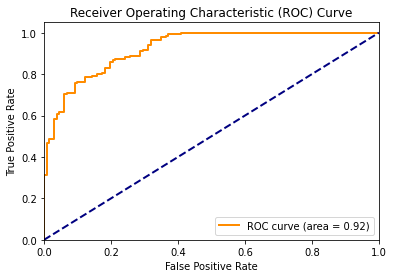

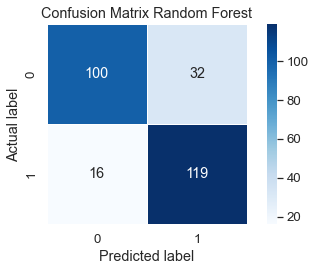

In [6]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Set the best parameters
best_params = {'max_depth':10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
best_rf = RandomForestClassifier(**best_params, random_state=42)

# Train the model
best_rf.fit(X_train, y_train)

# Predict and evaluate on the training set
y_train_pred = best_rf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Set Accuracy: {training_accuracy:.4f}")

# Predict and evaluate on the test set
y_pred_RF = best_rf.predict(X_test) 
test_accuracy = accuracy_score(y_test, y_pred_RF)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_RF)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_RF))

# ROC Curve using predicted probabilities
y_pred_proba_RF = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_RF)
roc_auc_RF = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix Random Forest')

# Adjust layout
plt.tight_layout()
plt.show()

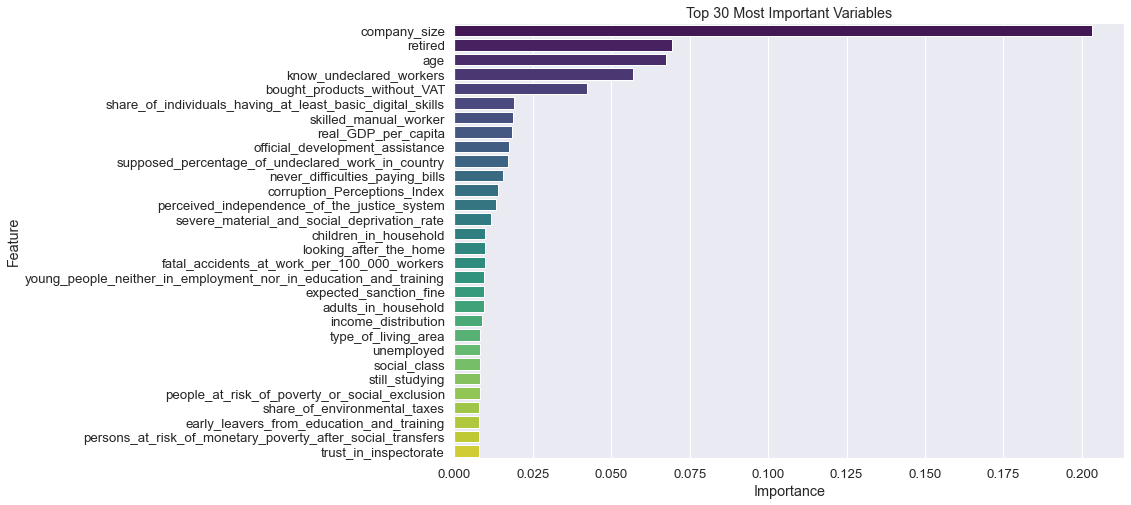

In [74]:

# Importance of variables
importances = best_rf.feature_importances_

# Get indices of top 30 features in descending order
top_indices = importances.argsort()[-30:][::-1]

# Get feature names
feature_names = X.columns

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': [feature_names[i] for i in top_indices], 'Importance': importances[top_indices]})

# Plot the importance of top 30 variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()

# 2. MLP Neural Network

In [5]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Functions for constructing model

In [6]:
def add_layers(layers_dict):
    # Initialization
    model = Sequential()

    # Add layers
    model.add(Input(shape=(126,))) # 126 = number of variables
    model.add(Dense(layers_dict['inic']['uni'], activation=layers_dict['inic']['activ']))
    for i in list(layers_dict.keys())[1:-2]:
        model.add(Dense(layers_dict[i]['uni'], activation=layers_dict[i]['activ']))      # hidden layer i
        if 'dropout' in layers_dict[i]:
            model.add(Dropout(rate=layers_dict[i]['dropout']))

    model.add(Dense(layers_dict['end']['uni'], activation=layers_dict['end']['activ']))  # exit layer

    # Compile model
    model.compile(loss=layers_dict['compile']['loss'],
                  optimizer=layers_dict['compile']['optimizer'],
                  metrics=layers_dict['compile']['metrics'])
    return model

In [7]:
def train_model(model, X_train, X_test, y_train, y_test, multiclass, **kwargs):
    epochs = kwargs.get('epochs', 5)
    batch_size = kwargs.get('batch_size', 1)
    verbose = kwargs.get('verbose', 1)
    
    # SET SEEDS
    np.random.seed(140)
    tf.random.set_seed(134)
    tf.keras.utils.set_random_seed(44)
    torch.manual_seed(140)

    # Training
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Predictions and evaluation
    y_pred = model.predict(X_test)
    if multiclass:
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)

        score = model.evaluate(X_test, y_test, verbose=1)
        conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
        classification_rep = classification_report(y_test_classes, y_pred_classes)

        # Put results in dataframe
        results = pd.Series({'Layers': (len(model.layers) - 2)/2,  # Excluding input and output layers, and dropouts
                             'Epochs': epochs,
                             'Batch_Size': batch_size,
                             'Test_Loss': score[0],
                             'Test_Accuracy': score[1],
                             'conf_matrix': conf_matrix,
                             'classification_rep': classification_rep
                             })

    else:
        y_pred = (y_pred > 0.5)
        score = model.evaluate(X_test, y_test, verbose=1)
        # print("Test Loss and Accuracy:", score)

        # Predictions and evaluation
        # conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test,y_pred)
        kappa = cohen_kappa_score(y_test, y_pred)

        # Put results in dataframe
        results = pd.Series({'Layers': (len(model.layers) - 2)/2,  # Excluding input and output layers, and dropouts
                                'Epochs': epochs,
                                'Batch_Size': batch_size,
                                'Test_Loss': score[0],
                                'Test_Accuracy': score[1],
                                'Precision': precision,
                                'Recall': recall,
                                'F1_Score': f1,
                                'Kappa_Score': kappa})

    return model, results

In [8]:
def get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1, multiclass=False):
    # SET SEEDS
    np.random.seed(140)
    tf.random.set_seed(134)
    tf.keras.utils.set_random_seed(44)
    torch.manual_seed(140)
    
    uni_ocultas = []
    f_activ = []
    for i in list(layers_dict.keys())[1:-2]:
        uni_ocultas.append(layers_dict[i]['uni'])
        f_activ.append(layers_dict[i]['activ'])

    # compile model
    model = add_layers(layers_dict)

    # train + predict model
    model, results_df = train_model(model, X_train, X_test, y_train, y_test, epochs=epochs, batch_size=batch_size, verbose=verbose, multiclass=multiclass)

    results_df['Hidden_Layers'] = str(uni_ocultas)
    results_df['F_activ'] = str(f_activ)
    results_df['Loss'] = layers_dict['compile']['loss']
    results_df['Optimizer'] = layers_dict['compile']['optimizer']
    if multiclass:
        results_df = results_df[['Layers', 'Hidden_Layers', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                  'classification_rep', 'conf_matrix']]
    else:
        results_df = results_df[['Layers', 'Hidden_Layers', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                            'Precision', 'Recall', 'F1_Score', 'Kappa_Score']]
    return model, results_df

# Search for best model

In [81]:
df_all_results_relu = pd.DataFrame(columns=['Layers', 'Hidden_Layers', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                        'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])

In [82]:
# SEARCH FOR BEST MODEL
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# List of common optimizers
optimizers = [
    'SGD',     # Stochastic Gradient Descent
    'Adam',    # Adam
    'Adamax'  # Adamax
]

start_time = time.time()

# Loop through the list of optimizers and compile the model with each one
for optimizer in optimizers:
    
    #RELU, 1 
    n = 0
    for l1 in [252, 126, 64, 32, 8,2]:
                n = n + 1
                layers_dict = {
                    'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                    'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                    'end' : {'uni': 1, 'activ': 'sigmoid'},
                    'compile' : {'loss': 'binary_crossentropy', 'optimizer' : optimizer, 'metrics' : ['accuracy']}
                }
                print(optimizer +  ": 1layer, " +  str(n) + "/6")
                model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                results_df = pd.DataFrame(results_df).T
                df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
                print()
    df_all_results_relu.to_csv('undersample_models_MLP_ew.csv', index=False)



    # RELU, 2 
    n = 0
    for l1 in [252, 126, 64]:
        for l2 in [126, 64, 32, 8, 4, 2]:
            n = n + 1
            layers_dict = {
                'inic' : {'uni': 126, 'activ': 'relu', 'input_s': (126,)}, 
                'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                'l2' : {'uni': l2, 'activ': 'relu', 'dropout': 0.2},
                'end' : {'uni': 1, 'activ': 'sigmoid'},
                'compile' : {'loss': 'binary_crossentropy', 'optimizer' : optimizer, 'metrics' : ['accuracy']}
            }
            print(optimizer +  ": 2layers, " +  str(n) + "/18")
            model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
            results_df = pd.DataFrame(results_df).T
            df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
            print()
    df_all_results_relu.to_csv('undersample_models_MLP_ew.csv', index=False)


    #RELU, 3 
    n=0
    for l1 in [252]:
        for l2 in [126, 64, 32]:
            for l3 in [64, 32, 8, 2]:
                n = n + 1
                layers_dict = {
                    'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                    'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                    'l2' : {'uni': l2, 'activ': 'relu', 'dropout': 0.2},
                    'l3' : {'uni': l3, 'activ': 'relu', 'dropout': 0.2},
                    'end' : {'uni': 1, 'activ': 'sigmoid'},
                    'compile' : {'loss': 'binary_crossentropy', 'optimizer' : optimizer, 'metrics' : ['accuracy']}
                }
                print(optimizer +  ": 3layers, " +  str(n) + "/12")
                model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                results_df = pd.DataFrame(results_df).T
                df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
                print()
    df_all_results_relu.to_csv('undersample_models_MLP_ew.csv', index=False)



    #RELU, 4 
    n = 0
    for l1 in [252]:
        for l2 in [126, 64, 32]:
            for l3 in [64, 32, 8]:
                for l4 in [ 32, 8, 4, 2]:
                    n = n + 1
                    layers_dict = {
                        'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                        'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                        'l2' : {'uni': l2, 'activ': 'relu', 'dropout': 0.2},
                        'l3' : {'uni': l3, 'activ': 'relu', 'dropout': 0.2},
                        'l4' : {'uni': l4, 'activ': 'relu', 'dropout': 0.2},
                        'end' : {'uni': 1, 'activ': 'sigmoid'},
                        'compile' : {'loss': 'binary_crossentropy', 'optimizer' : optimizer, 'metrics' : ['accuracy']}
                    }
                    print(optimizer +  ": 4layers, " +  str(n) + "/36")
                    model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                    results_df = pd.DataFrame(results_df).T
                    df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
                    print()
    df_all_results_relu.to_csv('undersample_models_MLP_ew.csv', index=False)


    #RELU, 5 
    n = 0
    for l1 in [252]:
        for l2 in [126, 64, 32]:
            for l3 in [64, 32, 8]:
                for l4 in [ 32, 8, 4]:
                    for l5 in [ 8, 4, 2]:
                        n = n + 1
                        layers_dict = {
                            'inic' : {'uni': 126, 'activ': 'relu', 'input_s':(126,)},
                            'l1' : {'uni': l1, 'activ': 'relu', 'dropout': 0.2},
                            'l2' : {'uni': l2, 'activ': 'relu', 'dropout': 0.2},
                            'l3' : {'uni': l3, 'activ': 'relu', 'dropout': 0.2},
                            'l4' : {'uni': l4, 'activ': 'relu', 'dropout': 0.2},
                            'l5' : {'uni': l5, 'activ': 'relu', 'dropout': 0.2},
                            'end' : {'uni': 1, 'activ': 'sigmoid'},
                            'compile' : {'loss': 'binary_crossentropy', 'optimizer' : optimizer, 'metrics' : ['accuracy']}
                        }
                        print(optimizer +  ": 5layers, " +  str(n) + "/81")
                        model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                        results_df = pd.DataFrame(results_df).T
                        df_all_results_relu = pd.concat([df_all_results_relu, results_df], ignore_index=True)
                        print()
    df_all_results_relu.to_csv('undersample_models_MLP_ew.csv', index=False)
    


end_time = time.time()
print("Elapsed time:", end_time - start_time, "seconds")

SGD: 1layer, 1/6
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - accuracy: 0.7075 - loss: 0.5572
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - accuracy: 0.8202 - loss: 0.3561
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.8736 - loss: 0.2787
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.9143 - loss: 0.2079
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.9296 - loss: 0.1667
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8665 - loss: 0.3841  

SGD: 1layer, 2/6
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step - accuracy: 0.6854 - loss: 0.5684
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.8394 - loss: 0.3459
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.8596 - loss: 0.2796
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - accuracy: 0.9027 - loss: 0.2166
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - accuracy: 0.6528 - loss: 0.6116
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.7977 - loss: 0.4020
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 795us/step - accuracy: 0.8445 - loss: 0.3195
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8864 - loss: 0.2675
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8980 - loss: 0.2183
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8530 - loss: 0.3839  

SGD: 2layers, 16/18
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.6216 - loss: 0.6408
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.8091 - loss: 0.4157
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8382 - loss: 0.3557
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.8644 - loss: 0.2735
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.8743 - l

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 862us/step - accuracy: 0.5250 - loss: 0.6917
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - accuracy: 0.7599 - loss: 0.4861
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - accuracy: 0.8386 - loss: 0.3729
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.8685 - loss: 0.3098
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.8980 - loss: 0.2469
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8452 - loss: 0.3563  

SGD: 4layers, 6/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - accuracy: 0.5764 - loss: 0.6646
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - accuracy: 0.7642 - loss: 0.4672
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - accuracy: 0.8238 - loss: 0.3700
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - accuracy: 0.8387 - loss: 0.3309
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - accuracy: 0.8842 - los

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 897us/step - accuracy: 0.5625 - loss: 0.6741
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step - accuracy: 0.7715 - loss: 0.4779
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.8304 - loss: 0.3802
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.8421 - loss: 0.3362
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.8671 - loss: 0.2977
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8372 - loss: 0.3310  

SGD: 4layers, 26/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 876us/step - accuracy: 0.5364 - loss: 0.6781
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.7837 - loss: 0.4843
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.8136 - loss: 0.4182
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - accuracy: 0.8628 - loss: 0.3248
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.8739 - lo

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 906us/step - accuracy: 0.5053 - loss: 0.6945
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - accuracy: 0.4691 - loss: 0.6968
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.4649 - loss: 0.6945
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.4654 - loss: 0.6945
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.4664 - loss: 0.6945
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4810 - loss: 0.6945  

SGD: 5layers, 10/81
Epoch 1/5


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 929us/step - accuracy: 0.5345 - loss: 0.6825
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.6865 - loss: 0.5552
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.7863 - loss: 0.4589
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - accuracy: 0.8402 - loss: 0.3781
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.8583 - loss: 0.3240
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8357 - loss: 0.4403  

SGD: 5layers, 11/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 920us/step - accuracy: 0.5669 - loss: 0.6602
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.7356 - loss: 0.5079
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.7994 - loss: 0.4241
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - accuracy: 0.8355 - loss: 0.3460
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step - accuracy: 0.8597 - l

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4700 - loss: 0.7001
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.5695 - loss: 0.6840
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6454 - loss: 0.6284
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6794 - loss: 0.6004
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6710 - loss: 0.5989
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7977 - loss: 0.5077  

SGD: 5layers, 28/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 937us/step - accuracy: 0.5420 - loss: 0.6743
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - accuracy: 0.7623 - loss: 0.4887
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.7976 - loss: 0.4189
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - accuracy: 0.8537 - loss: 0.3463
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 0.8468 - 

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 891us/step - accuracy: 0.5525 - loss: 0.6835
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - accuracy: 0.7280 - loss: 0.5282
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 885us/step - accuracy: 0.7495 - loss: 0.4940
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - accuracy: 0.8327 - loss: 0.3739
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.8143 - loss: 0.4285
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8335 - loss: 0.3683  

SGD: 5layers, 48/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 897us/step - accuracy: 0.5396 - loss: 0.6874
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.6304 - loss: 0.6446
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - accuracy: 0.7097 - loss: 0.5914
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.7826 - loss: 0.4851
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - accuracy: 0.7812 - lo

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - accuracy: 0.5223 - loss: 0.6925
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - accuracy: 0.5497 - loss: 0.6703
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.6916 - loss: 0.5453
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.7957 - loss: 0.4348
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.8019 - loss: 0.3991
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8483 - loss: 0.3399  

SGD: 5layers, 68/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 895us/step - accuracy: 0.5613 - loss: 0.6880
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.7043 - loss: 0.5873
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - accuracy: 0.7054 - loss: 0.5071
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - accuracy: 0.7476 - loss: 0.4386
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.7703 - lo

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 790us/step - accuracy: 0.6224 - loss: 0.6362
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.7449 - loss: 0.4500
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - accuracy: 0.7796 - loss: 0.3919
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.7997 - loss: 0.3372
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.8061 - loss: 0.3299
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8531 - loss: 0.3301 

Adam: 2layers, 1/18
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 949us/step - accuracy: 0.6864 - loss: 0.5913
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - accuracy: 0.8215 - loss: 0.3573
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.8717 - loss: 0.2801
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step - accuracy: 0.8946 - loss: 0.2226
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.9236 - lo

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6788 - loss: 0.6107
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8251 - loss: 0.3724
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8717 - loss: 0.3031
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8854 - loss: 0.2396
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9051 - loss: 0.2168
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8292 - loss: 0.4468  

Adam: 3layers, 3/12
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6596 - loss: 0.6175
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8009 - loss: 0.3881
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8439 - loss: 0.3310
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8765 - loss: 0.2997
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8659 - loss: 0.2446
9/9 ━━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6236 - loss: 0.6481
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8269 - loss: 0.4049
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8688 - loss: 0.3189
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8829 - loss: 0.2767
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9006 - loss: 0.2575
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8205 - loss: 0.4016  

Adam: 4layers, 6/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6167 - loss: 0.6475
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7808 - loss: 0.4196
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8138 - loss: 0.3622
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8438 - loss: 0.3106
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8838 - loss: 0.3178
9/9 ━━━━━

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8479 - loss: 0.3461
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8624 - loss: 0.3028
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8875 - loss: 0.2909
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8487 - loss: 0.4127  

Adam: 4layers, 26/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5996 - loss: 0.6357
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8056 - loss: 0.4107
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8236 - loss: 0.3614
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8244 - loss: 0.3252
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8506 - loss: 0.2789
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8546 - loss: 0.3731  

Adam: 4layers, 27/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/st

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4827 - loss: 0.7167
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4853 - loss: 0.6936
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4814 - loss: 0.6936
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4846 - loss: 0.6935
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4783 - loss: 0.6935
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4810 - loss: 0.6935  

Adam: 5layers, 10/81
Epoch 1/5


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6235 - loss: 0.6355
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7851 - loss: 0.5002
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8411 - loss: 0.3596
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8633 - loss: 0.3142
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8891 - loss: 0.2864
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8569 - loss: 0.3455  

Adam: 5layers, 11/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5658 - loss: 0.6684
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7129 - loss: 0.5246
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7807 - loss: 0.4162
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8435 - loss: 0.3618
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8575 - loss: 0.3049
9/9 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4789 - loss: 0.6958
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4792 - loss: 0.7068
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4802 - loss: 0.6935
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4811 - loss: 0.6935
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4840 - loss: 0.6935
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4810 - loss: 0.6935  

Adam: 5layers, 19/81
Epoch 1/5


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5894 - loss: 0.6585
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7802 - loss: 0.4590
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8003 - loss: 0.3683
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8335 - loss: 0.3555
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8475 - loss: 0.3016
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8357 - loss: 0.3828  

Adam: 5layers, 20/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5962 - loss: 0.6622
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7725 - loss: 0.4695
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8091 - loss: 0.4293
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8406 - loss: 0.3745
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8568 - loss: 0.3498
9/9 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5359 - loss: 0.6855
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6408 - loss: 0.5742
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7565 - loss: 0.4956
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8038 - loss: 0.4355
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8151 - loss: 0.4137
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8443 - loss: 0.3399  

Adam: 5layers, 23/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5967 - loss: 0.6550
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6939 - loss: 0.5183
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7465 - loss: 0.4764
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7664 - loss: 0.4320
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7840 - loss: 0.4251
9/9 ━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5791 - loss: 0.6616
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7512 - loss: 0.4899
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8081 - loss: 0.4133
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8509 - loss: 0.3576
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8642 - loss: 0.3582
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8356 - loss: 0.3661  

Adam: 5layers, 32/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5965 - loss: 0.6566
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7222 - loss: 0.5011
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7677 - loss: 0.4376
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7771 - loss: 0.4235
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7706 - loss: 0.4094
9/9 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4623 - loss: 0.7048
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4784 - loss: 0.6935
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4803 - loss: 0.6935
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4800 - loss: 0.6935
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4849 - loss: 0.6935
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4810 - loss: 0.6935  

Adam: 5layers, 37/81
Epoch 1/5


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5677 - loss: 0.6582
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7829 - loss: 0.4453
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8348 - loss: 0.3592
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8610 - loss: 0.3320
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8613 - loss: 0.2641
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8265 - loss: 0.4134  

Adam: 5layers, 38/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6103 - loss: 0.6493
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7478 - loss: 0.4697
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8011 - loss: 0.4006
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8246 - loss: 0.3724
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8281 - loss: 0.3462
9/9 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5616 - loss: 0.6681
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6984 - loss: 0.5287
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8037 - loss: 0.4273
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8251 - loss: 0.3747
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8417 - loss: 0.3627
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.3579  

Adam: 5layers, 41/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5864 - loss: 0.6492
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6943 - loss: 0.5110
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7498 - loss: 0.4432
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7480 - loss: 0.4157
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7725 - loss: 0.3716
9/9 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4595 - loss: 0.7042
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4838 - loss: 0.6937
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4830 - loss: 0.6936
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4846 - loss: 0.6935
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4913 - loss: 0.6927
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4810 - loss: 0.6936  

Adam: 5layers, 46/81
Epoch 1/5


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5453 - loss: 0.6836
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7869 - loss: 0.4920
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8174 - loss: 0.3904
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8385 - loss: 0.3335
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8490 - loss: 0.3164
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8565 - loss: 0.3945  

Adam: 5layers, 47/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6511 - loss: 0.6301
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7668 - loss: 0.4488
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7874 - loss: 0.4033
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8365 - loss: 0.3477
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8274 - loss: 0.3721
9/9 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5102 - loss: 0.7015
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5442 - loss: 0.6827
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6071 - loss: 0.6485
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6510 - loss: 0.6230
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6663 - loss: 0.5987
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7858 - loss: 0.5365  

Adam: 5layers, 55/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6089 - loss: 0.6334
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7706 - loss: 0.4616
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7977 - loss: 0.3891
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8560 - loss: 0.3345
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8919 - loss: 0.2722
9/9 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4510 - loss: 0.6961
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4743 - loss: 0.6961
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4861 - loss: 0.6934
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4852 - loss: 0.6935
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4799 - loss: 0.6935
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4810 - loss: 0.6935  

Adam: 5layers, 62/81
Epoch 1/5


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4692 - loss: 0.6994
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4644 - loss: 0.6935
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4760 - loss: 0.6932
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4761 - loss: 0.6934
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4782 - loss: 0.6935
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4810 - loss: 0.6935  

Adam: 5layers, 63/81
Epoch 1/5


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5075 - loss: 0.6918
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4874 - loss: 0.6990
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5470 - loss: 0.7099
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6409 - loss: 0.6367
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6636 - loss: 0.6311
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7879 - loss: 0.5426  

Adam: 5layers, 64/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6217 - loss: 0.6409
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7776 - loss: 0.4582
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8268 - loss: 0.3680
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8675 - loss: 0.3191
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8808 - loss: 0.2777
9/9 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6144 - loss: 0.6466
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7848 - loss: 0.4392
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8322 - loss: 0.3803
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8533 - loss: 0.3157
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8520 - loss: 0.3061
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8411 - loss: 0.3528  

Adam: 5layers, 74/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6152 - loss: 0.6541
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7816 - loss: 0.4648
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7886 - loss: 0.4232
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8281 - loss: 0.3679
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7918 - loss: 0.4148
9/9 ━━━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5162 - loss: 0.6968
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5717 - loss: 0.6760
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6348 - loss: 0.6382
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6372 - loss: 0.6305
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6692 - loss: 0.6003
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8228 - loss: 0.5046  

Adamax: 1layer, 1/6
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6816 - loss: 0.5655
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8190 - loss: 0.3762
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8388 - loss: 0.3185
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8764 - loss: 0.2690
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8977 - loss: 0.2413
9/9 ━━━━━

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7398 - loss: 0.4956
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7969 - loss: 0.4162
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8318 - loss: 0.3403
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8277 - loss: 0.3344
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8528 - loss: 0.3253  

Adamax: 2layers, 5/18
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5419 - loss: 0.6730
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7214 - loss: 0.5096
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7932 - loss: 0.4240
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8249 - loss: 0.3639
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8396 - loss: 0.3518
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8368

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8189 - loss: 0.3738
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8530 - loss: 0.3209
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8837 - loss: 0.2853
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8738 - loss: 0.3320  

Adamax: 2layers, 15/18
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6058 - loss: 0.6415
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7766 - loss: 0.4693
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8140 - loss: 0.3795
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8272 - loss: 0.3454
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8435 - loss: 0.3170
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8300 - loss: 0.3327  

Adamax: 2layers, 16/18
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7707 - loss: 0.4149
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8521 - loss: 0.3368  

Adamax: 4layers, 5/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5187 - loss: 0.7084
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7415 - loss: 0.5292
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8073 - loss: 0.4143
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8378 - loss: 0.3605
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8642 - loss: 0.3251
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8471 - loss: 0.3178  

Adamax: 4layers, 6/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5732 - loss: 0.6825
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7468 - loss: 0.5000
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8458 - loss: 0.3547  

Adamax: 4layers, 25/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5513 - loss: 0.6770
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7373 - loss: 0.5299
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7897 - loss: 0.4325
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8219 - loss: 0.3642
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8406 - loss: 0.3465
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8372 - loss: 0.3390  

Adamax: 4layers, 26/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5544 - loss: 0.6840
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7507 - loss: 0.5274
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7823 - loss: 0.4649
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8211 -

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5558 - loss: 0.6879
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6497 - loss: 0.6269
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7200 - loss: 0.5463
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7347 - loss: 0.5218
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8038 - loss: 0.4534
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8519 - loss: 0.3716  

Adamax: 4layers, 36/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4920 - loss: 0.6944
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6365 - loss: 0.6439
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6756 - loss: 0.5454
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6930 - loss: 0.5241
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7014 - loss: 0.4917
9/9 ━━

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5662 - loss: 0.6711
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6949 - loss: 0.5707
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7435 - loss: 0.5047
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8070 - loss: 0.4381
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8163 - loss: 0.3951
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8440 - loss: 0.3435  

Adamax: 5layers, 11/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5852 - loss: 0.6744
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6810 - loss: 0.5954
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7564 - loss: 0.5033
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7854 - loss: 0.4355
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7999 - loss: 0.3946
9/9 ━━

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6830 - loss: 0.6103
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7398 - loss: 0.5487
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7560 - loss: 0.5424
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8332 - loss: 0.4863  

Adamax: 5layers, 31/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5085 - loss: 0.6955
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6113 - loss: 0.6585
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7214 - loss: 0.5584
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7464 - loss: 0.4944
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7696 - loss: 0.4609
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8381 - loss: 0.3530  

Adamax: 5layers, 32/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2m

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7216 - loss: 0.5170
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7933 - loss: 0.4261  

Adamax: 5layers, 51/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5519 - loss: 0.6848
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6496 - loss: 0.6396
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6740 - loss: 0.6220
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6991 - loss: 0.5950
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7027 - loss: 0.5782
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8246 - loss: 0.5139  

Adamax: 5layers, 52/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4804 - loss: 0.6924
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6290 - loss: 0.6387
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2m

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8356 - loss: 0.4901  

Adamax: 5layers, 71/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5117 - loss: 0.6946
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6091 - loss: 0.6663
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6548 - loss: 0.6417
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6828 - loss: 0.6293
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7070 - loss: 0.5997
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8087 - loss: 0.5305  

Adamax: 5layers, 72/81
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4667 - loss: 0.6973
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5359 - loss: 0.6884
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6148 - loss: 0.6590
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6286 -

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4791 - loss: 0.6903
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5267 - loss: 0.6906
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6110 - loss: 0.6582
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6270 - loss: 0.6306
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6660 - loss: 0.6192
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8367 - loss: 0.5496  

Elapsed time: 4363.544184923172 seconds


In [100]:
df_all_results_relu.sort_values(by='Test_Accuracy', ascending=False).head(10)

,Layers,Hidden_Layers,F_activ,Loss,Optimizer,Epochs,Batch_Size,Test_Loss,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
348,4.0,"[252, 126, 32, 4]","['relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.326632,0.868914,0.847222,0.903704,0.874552,0.737596
325,2.0,"[64, 64]","['relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.341276,0.868914,0.847222,0.903704,0.874552,0.737596
337,3.0,"[252, 64, 2]","['relu', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.416879,0.861423,0.822368,0.925926,0.87108,0.722414
358,4.0,"[252, 64, 32, 32]","['relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.320388,0.861423,0.826667,0.918519,0.870175,0.722461
283,5.0,"[252, 32, 64, 8, 4]","['relu', 'relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.364918,0.857678,0.808917,0.940741,0.869863,0.714792
314,2.0,"[252, 32]","['relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.325566,0.857678,0.843972,0.881481,0.862319,0.715176
368,4.0,"[252, 32, 64, 4]","['relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.334224,0.857678,0.825503,0.911111,0.866197,0.714984
0,1.0,[252],['relu'],binary_crossentropy,SGD,5.0,1.0,0.404815,0.853933,0.875,0.82963,0.851711,0.708
53,4.0,"[252, 64, 32, 8]","['relu', 'relu', 'relu', 'relu']",binary_crossentropy,SGD,5.0,1.0,0.336638,0.853933,0.803797,0.940741,0.866894,0.707262
174,2.0,"[64, 8]","['relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.451134,0.853933,0.82,0.911111,0.863158,0.707459


# Experimentation - changing activation functions

In [121]:
df_all_results_tanh = pd.DataFrame(columns=['Layers', 'Hidden_Layers', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                        'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])

Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5750 - loss: 0.7284
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7459 - loss: 0.5160
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8013 - loss: 0.4384
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8271 - loss: 0.3827
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8076 - loss: 0.3417
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8514 - loss: 0.3335  
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training Accuracy: 0.9033
Test Accuracy: 0.8502
Confusion Matrix:
[[105  27]
 [ 13 122]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       132
           1       0.82      0.90      0.86       135

    accuracy                           0.85       267
   macro avg       0.85      0.85      0.85       267
weighted avg       0.85      0.8

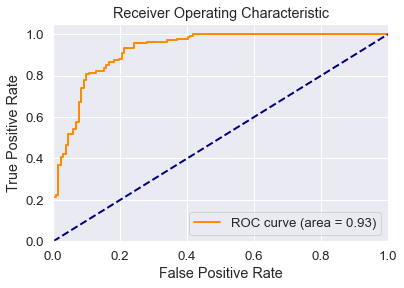

In [132]:
#4.0	[252, 126, 32, 4]	['relu', 'relu', 'relu', 'relu']	binary_crossentropy 	Adamax	
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

layers_dict = {
            'inic' : {'uni': 126, 'activ': 'relu', 'input_s': (126,)},
            'l1' : {'uni': 252, 'activ': 'relu', 'dropout': 0.2},
            'l2' : {'uni': 126, 'activ': 'relu', 'dropout': 0.2},
            'l3' : {'uni': 32, 'activ': 'tanh', 'dropout': 0.2},
            'l4' : {'uni': 4, 'activ': 'relu', 'dropout': 0.2},
            'end' : {'uni': 1, 'activ': 'sigmoid'},
            'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'Adamax', 'metrics' : ['accuracy']}
        }

model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_tanh = pd.concat([df_all_results_tanh, results_df], ignore_index=True)

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.4f}')

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['0', '1']))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6636 - loss: 0.6223
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8058 - loss: 0.4315
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8319 - loss: 0.3654
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8647 - loss: 0.3010
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8933 - loss: 0.2545
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8406 - loss: 0.3401  
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
Training Accuracy: 0.9230
Test Accuracy: 0.8315
Confusion Matrix:
[[107  25]
 [ 20 115]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       132
           1       0.82      0.85      0.84       135

    accuracy                           0.83       267
   macro avg       0.83      0.83      0.83       267
weighted avg       0.83      0.8

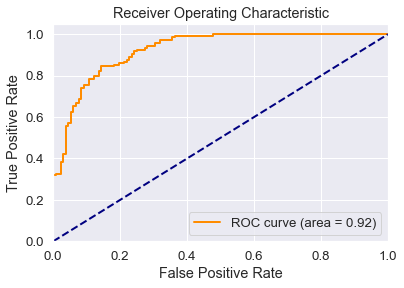

In [138]:
# 2.0	[64, 64]	['relu', 'relu']	binary_crossentropy 	Adamx

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

layers_dict = {
            'inic' : {'uni': 126, 'activ': 'relu', 'input_s': (126,)},
            'l1' : {'uni': 64, 'activ': 'relu', 'dropout': 0.2},
            'l2' : {'uni': 64, 'activ': 'tanh', 'dropout': 0.2},
            'end' : {'uni': 1, 'activ': 'sigmoid'},
            'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'Adamax', 'metrics' : ['accuracy']}
        }

model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_tanh = pd.concat([df_all_results_tanh, results_df], ignore_index=True)

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.4f}')

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['0', '1']))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6164 - loss: 0.6592
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7556 - loss: 0.5478
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7993 - loss: 0.5128
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8259 - loss: 0.4609
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8251 - loss: 0.4302
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8551 - loss: 0.4078  
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Training Accuracy: 0.8770
Test Accuracy: 0.8390
Confusion Matrix:
[[ 98  34]
 [  9 126]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       132
           1       0.79      0.93      0.85       135

    accuracy                           0.84       267
   macro avg       0.85      0.84      0.84       267
weighted avg       0.85      0.84

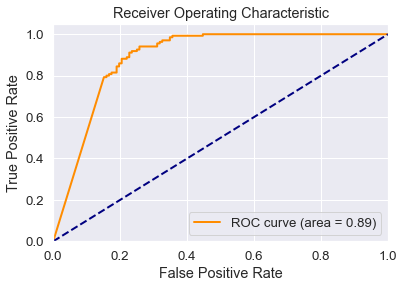

In [145]:
# 3.0	[252, 64, 2]	['relu', 'relu', 'relu']	binary_crossentropy 	Adamax

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

layers_dict = {
            'inic' : {'uni': 126, 'activ': 'tanh', 'input_s': (126,)},
            'l1' : {'uni': 252, 'activ': 'relu', 'dropout': 0.2},
            'l2' : {'uni': 64, 'activ': 'relu', 'dropout': 0.2},
            'l3' : {'uni': 2, 'activ': 'relu', 'dropout': 0.2},
            'end' : {'uni': 1, 'activ': 'sigmoid'},
            'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'Adamax', 'metrics' : ['accuracy']}
        }

model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_tanh = pd.concat([df_all_results_tanh, results_df], ignore_index=True)

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.4f}')

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['0', '1']))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [146]:
df_all_results_tanh.sort_values(by='Test_Accuracy', ascending=False)

,Layers,Hidden_Layers,F_activ,Loss,Optimizer,Epochs,Batch_Size,Test_Loss,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
0,4.0,"[252, 126, 32, 4]","['relu', 'relu', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.352079,0.861423,0.822368,0.925926,0.87108,0.722414
8,4.0,"[252, 126, 32, 4]","['relu', 'relu', 'relu', 'tanh']",binary_crossentropy,Adamax,5.0,1.0,0.345178,0.857678,0.821192,0.918519,0.867133,0.714936
10,2.0,"[64, 64]","['relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.351815,0.853933,0.828767,0.896296,0.86121,0.707558
16,3.0,"[252, 64, 2]","['relu', 'tanh', 'tanh']",binary_crossentropy,Adamax,5.0,1.0,0.383389,0.850187,0.823129,0.896296,0.858156,0.700034
9,4.0,"[252, 126, 32, 4]","['relu', 'relu', 'tanh', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.342188,0.850187,0.818792,0.903704,0.859155,0.699983
13,2.0,"[64, 64]","['relu', 'tanh']",binary_crossentropy,Adamax,5.0,1.0,0.354184,0.842697,0.82069,0.881481,0.85,0.685088
2,4.0,"[252, 126, 32, 4]","['tanh', 'tanh', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.36864,0.842697,0.82069,0.881481,0.85,0.685088
4,4.0,"[252, 126, 32, 4]","['tanh', 'tanh', 'tanh', 'tanh']",binary_crossentropy,Adamax,5.0,1.0,0.395074,0.842697,0.82069,0.881481,0.85,0.685088
6,4.0,"[252, 126, 32, 4]","['relu', 'tanh', 'tanh', 'tanh']",binary_crossentropy,Adamax,5.0,1.0,0.380688,0.842697,0.812081,0.896296,0.852113,0.684982
15,3.0,"[252, 64, 2]","['relu', 'relu', 'tanh']",binary_crossentropy,Adamax,5.0,1.0,0.381811,0.842697,0.812081,0.896296,0.852113,0.684982


In [148]:
df_all_results_tanh.to_csv('undersample_models_MLP_tanh_ew.csv', index=False)

## Final MLP model

Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5610 - loss: 0.6822
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7042 - loss: 0.5336
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7733 - loss: 0.4578
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8186 - loss: 0.4270
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8134 - loss: 0.3742
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8803 - loss: 0.3075  
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
Training Accuracy: 0.9005
Test Accuracy: 0.8689
Confusion Matrix:
[[110  22]
 [ 13 122]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       132
           1       0.85      0.90      0.87       135

    accuracy                           0.87       267
   macro avg       0.87      0.87      0.87       267
weighted avg       0.87      0.

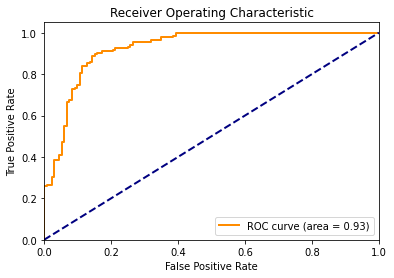

In [9]:
#4.0	[252, 126, 32, 4]	['relu', 'relu', 'relu', 'relu']	binary_crossentropy 	Adamax	
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

layers_dict = {
            'inic' : {'uni': 126, 'activ': 'relu', 'input_s': (126,)},
            'l1' : {'uni': 252, 'activ': 'relu', 'dropout': 0.2},
            'l2' : {'uni': 126, 'activ': 'relu', 'dropout': 0.2},
            'l3' : {'uni': 32, 'activ': 'relu', 'dropout': 0.2},
            'l4' : {'uni': 4, 'activ': 'relu', 'dropout': 0.2},
            'end' : {'uni': 1, 'activ': 'sigmoid'},
            'compile' : {'loss': 'binary_crossentropy', 'optimizer' : 'Adamax', 'metrics' : ['accuracy']}
        }

model, results_df = get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T

# Predict on the test set
y_pred_prob_MLP = model.predict(X_test)
y_pred_MLP = (y_pred_prob_MLP> 0.5).astype(int)

# Evaluate the model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Accuracy: {train_accuracy:.4f}')

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_MLP)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_MLP, target_names=['0', '1']))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_MLP)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

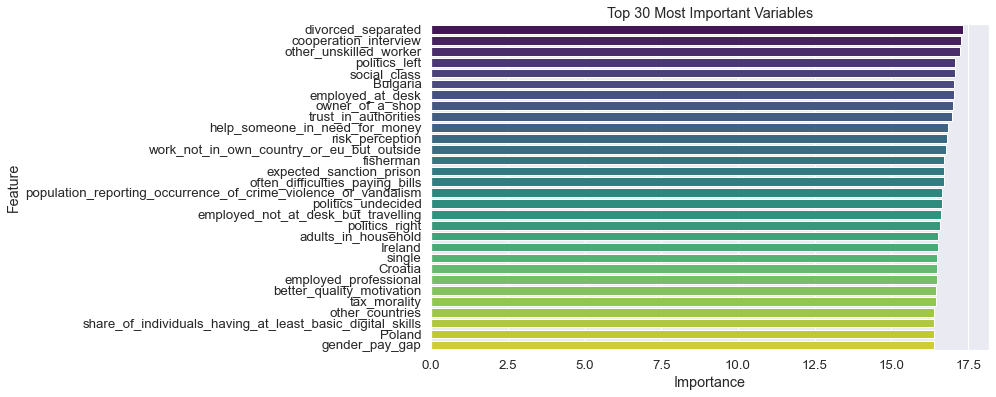

In [149]:
# Get the weights of the connections between the input layer and the first hidden layer
weights_layer1 = model.layers[1].get_weights()[0]  # Assuming 'l1' is the second layer in your model

# Calculate the absolute sum of weights for each input feature
feature_importance = np.abs(weights_layer1).sum(axis=1)

# Get the names of the input features from the DataFrame columns
input_feature_names = list(X.columns)

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': input_feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select only the top 30 most important variables
top_30_importance_df = importance_df.head(30)

# Plot the importance of top 30 variables
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_30_importance_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()

# 3. Tab Net with CV

In [6]:
# Grid Search

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert pandas DataFrame to numpy array
X_train_array = X_train.values
X_test_array = X_test.values

# Define the parameter grid for the grid search
param_grid = {
    'gamma': [1.0, 1.5, 2.0],
    'lambda_sparse': [0.0, 1e-5, 1e-4],
    'mask_type': ['sparsemax', 'entmax'],
    'n_a': [16, 32, 64],
    'n_d': [8, 16, 32],
    'n_independent': [1, 2],
    'n_shared': [1, 2],
    'n_steps': [3, 5, 7],
    'optimizer_fn': [torch.optim.Adam, torch.optim.AdamW],
    'optimizer_params': [{'lr': 0.02}, {'lr': 0.01}]
}

# Initialize the TabNetClassifier
tabnet_model = TabNetClassifier()

# Define cross-validation strategy (Stratified K-Fold with 5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tabnet_model, param_grid=param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=2)

# Perform grid search on training set
grid_search.fit(X_train_array, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))



C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Fitting 5 folds for each of 7776 candidates, totalling 38880 fits


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.87408 |  0:00:00s
epoch 1  | loss: 0.80554 |  0:00:00s
epoch 2  | loss: 0.79763 |  0:00:00s
epoch 3  | loss: 0.73537 |  0:00:00s
epoch 4  | loss: 0.7433  |  0:00:01s
epoch 5  | loss: 0.73417 |  0:00:01s
epoch 6  | loss: 0.70212 |  0:00:01s
epoch 7  | loss: 0.68985 |  0:00:01s
epoch 8  | loss: 0.69166 |  0:00:01s
epoch 9  | loss: 0.6912  |  0:00:01s
epoch 10 | loss: 0.67845 |  0:00:01s
epoch 11 | loss: 0.68356 |  0:00:02s
epoch 12 | loss: 0.665   |  0:00:02s
epoch 13 | loss: 0.66239 |  0:00:02s
epoch 14 | loss: 0.66075 |  0:00:02s
epoch 15 | loss: 0.66345 |  0:00:02s
epoch 16 | loss: 0.65236 |  0:00:02s
epoch 17 | loss: 0.64701 |  0:00:02s
epoch 18 | loss: 0.64504 |  0:00:03s
epoch 19 | loss: 0.63407 |  0:00:03s
epoch 20 | loss: 0.63612 |  0:00:03s
epoch 21 | loss: 0.63948 |  0:00:03s
epoch 22 | loss: 0.61883 |  0:00:03s
epoch 23 | loss: 0.60408 |  0:00:03s
epoch 24 | loss: 0.58751 |  0:00:03s
epoch 25 | loss: 0.58404 |  0:00:04s
epoch 26 | loss: 0.5772  |  0:00:04s
e

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# Ensure reproducibility
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert pandas DataFrame to numpy array
X_train_array = X_train.values
X_test_array = X_test.values

# Initialize the TabNetClassifier with the best parameters
tabnet_model = TabNetClassifier(
    gamma=2.0,
    lambda_sparse=0.0,
    mask_type='sparsemax',
    n_a=64,
    n_d=8,
    n_independent=2,
    n_shared=1,
    n_steps=5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': 0.02}
)


# Define cross-validation strategy (Stratified K-Fold with 5 folds)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on training set
cv_scores = cross_val_score(tabnet_model, X_train_array, y_train, cv=skf, scoring='accuracy')
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: {:.2f}".format(cv_scores.mean()))

# Fit the model to the entire training data
tabnet_model.fit(X_train_array, y_train)


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.87408 |  0:00:00s
epoch 1  | loss: 0.80554 |  0:00:00s
epoch 2  | loss: 0.79763 |  0:00:00s
epoch 3  | loss: 0.73537 |  0:00:00s
epoch 4  | loss: 0.7433  |  0:00:00s
epoch 5  | loss: 0.73417 |  0:00:00s
epoch 6  | loss: 0.70212 |  0:00:00s
epoch 7  | loss: 0.68985 |  0:00:01s
epoch 8  | loss: 0.69166 |  0:00:01s
epoch 9  | loss: 0.6912  |  0:00:01s
epoch 10 | loss: 0.67845 |  0:00:01s
epoch 11 | loss: 0.68356 |  0:00:01s
epoch 12 | loss: 0.665   |  0:00:01s
epoch 13 | loss: 0.66239 |  0:00:01s
epoch 14 | loss: 0.66075 |  0:00:02s
epoch 15 | loss: 0.66345 |  0:00:02s
epoch 16 | loss: 0.65236 |  0:00:02s
epoch 17 | loss: 0.64701 |  0:00:02s
epoch 18 | loss: 0.64504 |  0:00:02s
epoch 19 | loss: 0.63407 |  0:00:02s
epoch 20 | loss: 0.63612 |  0:00:02s
epoch 21 | loss: 0.63948 |  0:00:03s
epoch 22 | loss: 0.61883 |  0:00:03s
epoch 23 | loss: 0.60408 |  0:00:03s
epoch 24 | loss: 0.58751 |  0:00:03s
epoch 25 | loss: 0.58404 |  0:00:03s
epoch 26 | loss: 0.5772  |  0:00:03s
e

Training Accuracy: 0.631924882629108
Testing Accuracy: 0.6629213483146067

Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.72      0.52      0.61       132
           1       0.63      0.80      0.71       135

    accuracy                           0.66       267
   macro avg       0.68      0.66      0.66       267
weighted avg       0.67      0.66      0.66       267



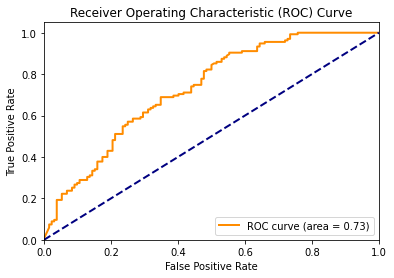

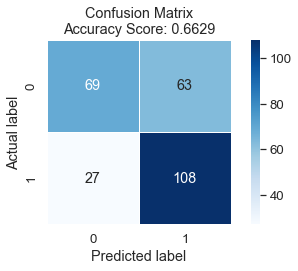

In [8]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Predict on training and testing data
y_train_pred = tabnet_model.predict(X_train_array)
y_test_pred_TABNET = tabnet_model.predict(X_test_array)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred_TABNET)

# Print train and test accuracy
print("Training Accuracy:", train_acc)
print("Testing Accuracy:", test_acc)

# Generate classification report
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_test_pred_TABNET))

# Plot ROC curve
# Predict probabilities for the test set
y_prob_TABNET = tabnet_model.predict_proba(X_test_array)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_prob_TABNET)  
roc_auc_TABNET = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_TABNET)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot heatmap of the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_TABNET)
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix\nAccuracy Score: {test_acc:.4f}')

# Adjust layout
plt.tight_layout()
plt.show()

Top 30 Feature Importances:
                                        Feature  Importance
88                          adults_in_household    0.272413
0                                           age    0.123261
37                                      retired    0.099542
123             official_development_assistance    0.064294
107  participation_in_early_childhood_education    0.047353
55                      know_undeclared_workers    0.046436
42                         business_proprietors    0.037268
65                    faster_service_motivation    0.033718
23                                       Poland    0.027380
68                            favour_motivation    0.026558
9                                    Luxembourg    0.026312
85                               still_studying    0.022710
27                                      Romania    0.018250
110                       gender_employment_gap    0.016885
117                         income_distribution    0.014941
80          

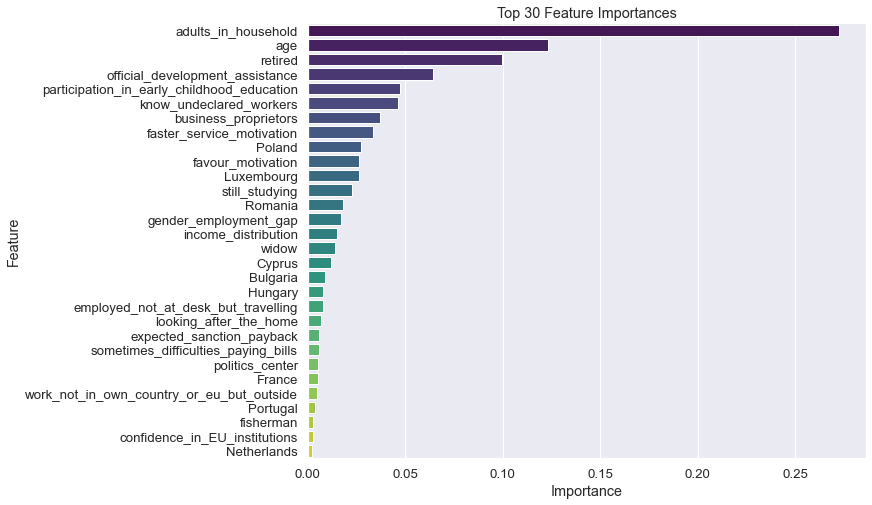

In [9]:
# Calculate feature importance
feature_importances = tabnet_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top 30 most important features
top_30_features = feature_importance_df.head(30)

# Print top 30 feature importance
print("Top 30 Feature Importances:")
print(top_30_features)

# Plot top 30 feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_30_features, palette='viridis')
plt.title('Top 30 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 4. Convolutional Neural Networks

In [85]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#SET SEED
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions of X_train:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Dimensions of X_train: (1065, 126)
Dimensions of X_test: (267, 126)
Dimensions of y_train: (1065,)
Dimensions of y_test: (267,)


In [86]:

#Reshape the data into 2D grid-like structure based on the data's dimensions
# Here, we reshape it into a 14x9 grid
X_train_reshaped = X_train_scaled.reshape(-1, 14, 9, 1)
X_test_reshaped = X_test_scaled.reshape(-1, 14, 9, 1)
print("Dimensions of X_train_reshaped:", X_train_reshaped.shape)
print("Dimensions of X_test_reshaped:", X_test_reshaped.shape)


Dimensions of X_train_reshaped: (1065, 14, 9, 1)
Dimensions of X_test_reshaped: (267, 14, 9, 1)


##  Functions to automatize experimenting-----------------------------------------

In [101]:
def add_layers(layers_dict):
    
    # SET SEEDS
    np.random.seed(140)
    tf.random.set_seed(134)
    tf.keras.utils.set_random_seed(44)
    torch.manual_seed(140)
    
    # Initialization
    model = Sequential()

    # Add input layer
    model.add(Input(shape=layers_dict['inic']['shape']))  

    # Add convolutional layers and pooling layers
    for i in range(1, len(layers_dict) - 2):  # Iterate over keys except 'inic' and 'end'
        conv_layer_info = layers_dict.get(f'conv{i}', None)
        pool_layer_info = layers_dict.get(f'pool{i}', None)
        
        if conv_layer_info:
            model.add(Conv2D(filters=conv_layer_info['filters'],
                             kernel_size=conv_layer_info['kernel_size'],
                             activation=conv_layer_info['activation'],
                             padding='same'))  # Use 'same' padding here
        if pool_layer_info:
            model.add(MaxPooling2D(pool_size=pool_layer_info['pool_size']))

    # Add flatten layer
    model.add(Flatten())

    # Add dense layers
    for i in range(1, len(layers_dict) - 2):
        dense_layer_info = layers_dict.get(f'dense{i}', None)
        if dense_layer_info:
            model.add(Dense(units=dense_layer_info['units'], activation=dense_layer_info['activation']))
            if 'dropout' in dense_layer_info:
                model.add(Dropout(rate=dense_layer_info['dropout']))

    # Add exit layer
    model.add(Dense(units=layers_dict['end']['units'], activation=layers_dict['end']['activation']))

    # Compile model
    model.compile(loss=layers_dict['compile']['loss'],
                  optimizer=layers_dict['compile']['optimizer'],
                  metrics=layers_dict['compile']['metrics'])
    
    return model

#--------------------------------------------------------------------------------------------------------
# Helper functions to count layers
def count_conv_layers(model):
    return sum(1 for layer in model.layers if isinstance(layer, Conv2D))

def count_pooling_layers(model):
    return sum(1 for layer in model.layers if isinstance(layer, MaxPooling2D))

def count_flatten_layers(model):
    return sum(1 for layer in model.layers if isinstance(layer, Flatten))

def count_dense_layers(model):
    # Exclude the output layer by iterating through all layers except the last one
    return sum(1 for layer in model.layers[:-1] if isinstance(layer, Dense))

#--------------------------------------------------------------------------------------------------------
def train_conv_model(model, X_train, X_test, y_train, y_test, **kwargs):
    epochs = kwargs.get('epochs', 5)
    batch_size = kwargs.get('batch_size', 1)
    verbose = kwargs.get('verbose', 1)
    
    # SET SEEDS
    np.random.seed(140)
    tf.random.set_seed(134)
    tf.keras.utils.set_random_seed(44)
    torch.manual_seed(140)

    # Training
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Predictions and evaluation on the test set
    y_pred_prob = model.predict(X_test)  
    y_pred = (y_pred_prob > 0.5)
    test_score = model.evaluate(X_test, y_test, verbose=1)
    
    # Evaluation on the training set
    train_score = model.evaluate(X_train, y_train, verbose=1)
    train_accuracy = train_score[1]
    test_accuracy = test_score[1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    # Put results in dataframe
    results = pd.Series({'Convolutional': count_conv_layers(model),
                         'Pooling': count_pooling_layers(model),
                         'Flatten': count_flatten_layers(model),
                         'Dense': count_dense_layers(model),
                         'Epochs': epochs,
                         'Batch_Size': batch_size,
                         'Test_Loss': test_score[0],
                         'Test_Accuracy': test_accuracy,
                         'Train_Accuracy': train_accuracy,
                         'Precision': precision,
                         'Recall': recall,
                         'F1_Score': f1,
                         'Kappa_Score': kappa})

    return model, results, y_pred, y_pred_prob, train_accuracy, test_accuracy

#----------------------------------------------------------------------------------------------------------------
def get_results(X_train, X_test, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1):
  
    hidden = []
    f_activ = []
    for key in list(layers_dict.keys())[1:-2]:
        layer = layers_dict[key]
        if layer['type'] == 'conv2d' or layer['type'] == 'dense':
            if 'filters' in layer:
                hidden.append(layer['filters'])
            elif 'units' in layer:
                hidden.append(layer['units'])
            if 'activation' in layer:
                f_activ.append(layer['activation'])
                
    # SET SEEDS
    np.random.seed(140)
    tf.random.set_seed(134)
    tf.keras.utils.set_random_seed(44)
    torch.manual_seed(140)          

    model = add_layers(layers_dict)
    model, results_df, y_pred, y_pred_prob, train_accuracy, test_accuracy = train_conv_model(model, X_train, X_test, y_train, y_test, epochs=epochs, batch_size=batch_size, verbose=verbose)

    results_df['Hidden_units'] = str(hidden)
    results_df['F_activ'] = str(f_activ)
    results_df['Loss'] = layers_dict['compile']['loss']
    results_df['Optimizer'] = layers_dict['compile']['optimizer']
    
    results_df = results_df[['Convolutional', 'Pooling', 'Flatten', 'Dense', 'Hidden_units', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                             'Precision', 'Recall', 'F1_Score', 'Kappa_Score']]

    return model, results_df, y_pred, y_pred_prob, train_accuracy, test_accuracy

In [88]:
#Form dataset to store models
df_all_results_CONV = pd.DataFrame(columns=['Convolutional', 'Pooling', 'Flatten', 'Dense', 'Hidden_units', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                            'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])
              

## FIND BEST CONVOLUTIONAL MODELS

In [89]:
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)


#Form dataset to store results of models
df_all_results_CONV = pd.DataFrame(columns=['Convolutional', 'Pooling', 'Flatten', 'Dense', 'Hidden_units', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                            'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])

# List of common optimizers
optimizers = [
    'SGD',     # Stochastic Gradient Descent
    'Adam',    # Adam
    'Adamax'  # Adamax
]


    
# Loop through the list of optimizers and compile the model with each one
start_time = time.time()
for optimizer in optimizers:
    
    #RELU, 1 filtru, 1 strat-----------------------------------------------------------------------------------------------
   
    n = 0
    for f1 in [128, 64, 32, 16]:
        for d1 in [252, 126, 64, 32]:
                n = n + 1
                layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu'},                          # Dense layer 1
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': optimizer, 'metrics': ['accuracy']}
                }

                print(optimizer +  ": 1filter, 1layer, " +  str(n) + "/16")
                model, results_df, predictions_CNN, predictions_proba_CNN, train_accuracyCNN, test_accuracyCNN = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                results_df = pd.DataFrame(results_df).T
                df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                print()

    df_all_results_CONV.to_csv('undersample_models_CNN_ew.csv', index=False)



    # RELU, 2 filtre, 1 strat-------------------------------------------------------------------------------------------------
    n = 0
    for f1 in [128, 64, 32]:
        for f2 in [64, 32, 16]:
            for d1 in [252, 126, 64, 32]:
                n = n + 1
                
                layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'conv2': {'type': 'conv2d', 'filters': f2, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool2': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu'},                          # Dense layer 1
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': optimizer, 'metrics': ['accuracy']}
                }

                print(optimizer +  ": 2filters, 1layer, " +  str(n) + "/36")
                model, results_df, predictions_CNN, predictions_proba_CNN, train_accuracyCNN, test_accuracyCNN = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                results_df = pd.DataFrame(results_df).T
                df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                print()

    df_all_results_CONV.to_csv('undersample_models_CNN_ew.csv', index=False)


     #RELU, 1 filtru, 2 straturi------------------------------------------------------------------------------------------------
    n = 0
    for f1 in [128, 64, 32, 16]:
        for d1 in [252, 126, 64, 32]:
            for d2 in [ 64, 32]:
                n = n + 1
                layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu'},                          # Dense layer 1
                            'dense2': {'type': 'dense', 'units': d2, 'activation': 'relu'},
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': optimizer, 'metrics': ['accuracy']}
                }

                print(optimizer +  ": 1filter, 2layers, " +  str(n) + "/32")  
                model, results_df, predictions_CNN, predictions_proba_CNN, train_accuracyCNN, test_accuracyCNN = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                results_df = pd.DataFrame(results_df).T
                df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                print()

    df_all_results_CONV.to_csv('undersample_models_CNN_ew.csv', index=False)

    
     #RELU, 2 filtre, 2 straturi------------------------------------------------------------------------------------------------
    n = 0
    for f1 in [128, 64, 32 ]:
        for f2 in [ 32, 16]:
            for d1 in [252, 126, 64]:
                for d2 in [ 64, 32]:
                    n = n + 1
                    layers_dict = {
                            'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                            'conv1': {'type': 'conv2d', 'filters': f1, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                            'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                            'flatten': {'type': 'flatten'},                                                           # Flatten layer
                            'dense1': {'type': 'dense', 'units': d1, 'activation': 'relu'},                          # Dense layer 1
                            'dense2': {'type': 'dense', 'units': d2, 'activation': 'relu'},
                            'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                            'compile': {'loss': 'binary_crossentropy', 'optimizer': optimizer, 'metrics': ['accuracy']}
                    }

                    print(optimizer +  ": 2filters, 2layers, " +  str(n) + "/36")
                    model, results_df, predictions_CNN, predictions_proba_CNN, train_accuracyCNN, test_accuracyCNN = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                    #model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
                    results_df = pd.DataFrame(results_df).T
                    df_all_results_CONV = pd.concat([df_all_results_CONV, results_df], ignore_index=True)
                    print()
                    
    df_all_results_CONV.to_csv('undersample_models_CNN_ew.csv', index=False)

end_time = time.time()
print("Elapsed time:", end_time - start_time, "seconds")

SGD: 1filter, 1layer, 1/16
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6935 - loss: 0.5745
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8209 - loss: 0.4066
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8337 - loss: 0.3676
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8411 - loss: 0.3379
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8531 - loss: 0.3125
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8448 - loss: 0.3646  

SGD: 1filter, 1layer, 2/16
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6768 - loss: 0.5800
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8211 - loss: 0.4102
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8312 - loss: 0.3696
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8468 - loss: 0.3414
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6188 - loss: 0.6319
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7997 - loss: 0.4594
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8177 - loss: 0.3946
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8418 - loss: 0.3519
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8594 - loss: 0.3215
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8187 - loss: 0.4146  

SGD: 2filters, 1layer, 6/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6630 - loss: 0.6191
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7984 - loss: 0.4516
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8155 - loss: 0.3945
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8379 - loss: 0.3580
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8536 - loss: 0.3250
9

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6021 - loss: 0.6418
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7846 - loss: 0.4656
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8171 - loss: 0.4011
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8305 - loss: 0.3543
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8557 - loss: 0.3098
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8281 - loss: 0.3724  

SGD: 2filters, 1layer, 26/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5926 - loss: 0.6441
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7732 - loss: 0.4720
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8225 - loss: 0.4069
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8261 - loss: 0.3666
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8480 - loss: 0.3264


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6730 - loss: 0.5923
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8239 - loss: 0.4192
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8330 - loss: 0.3702
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8432 - loss: 0.3345
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8655 - loss: 0.3011
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8542 - loss: 0.3865  

SGD: 1filter, 2layers, 10/32
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6578 - loss: 0.6012
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8196 - loss: 0.4234
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8331 - loss: 0.3779
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8445 - loss: 0.3483
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8459 - loss: 0.3212


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6627 - loss: 0.6108
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7917 - loss: 0.4383
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8236 - loss: 0.3882
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8331 - loss: 0.3512
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8449 - loss: 0.3237
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8250 - loss: 0.3940  

SGD: 1filter, 2layers, 30/32
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6357 - loss: 0.6211
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7996 - loss: 0.4322
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8163 - loss: 0.3870
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8397 - loss: 0.3550
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8487 - loss: 0.3280

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6462 - loss: 0.6123
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8119 - loss: 0.4311
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8292 - loss: 0.3797
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8404 - loss: 0.3460
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8418 - loss: 0.3198
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8259 - loss: 0.3700  

SGD: 2filters, 2layers, 18/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6726 - loss: 0.6013
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8155 - loss: 0.4278
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8393 - loss: 0.3873
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8374 - loss: 0.3478
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8517 - loss: 0.3251

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6804 - loss: 0.6939
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7936 - loss: 0.4181
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8244 - loss: 0.3822
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.8348 - loss: 0.3508
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8404 - loss: 0.3295
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8253 - loss: 0.3917

Adam: 1filter, 1layer, 2/16
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6773 - loss: 0.6534
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7978 - loss: 0.4192
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8154 - loss: 0.3802
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8387 - loss: 0.3497
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8584 - loss: 0.3236

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6202 - loss: 0.6539
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7655 - loss: 0.4884
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8047 - loss: 0.4406
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8184 - loss: 0.4009
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8261 - loss: 0.3681
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8347 - loss: 0.4007  

Adam: 2filters, 1layer, 6/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6574 - loss: 0.6197
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8033 - loss: 0.4499
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7976 - loss: 0.4024
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8177 - loss: 0.3618
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8425 - loss: 0.3285


1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6590 - loss: 0.6550
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7833 - loss: 0.4734
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8199 - loss: 0.4010
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8476 - loss: 0.3407
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8708 - loss: 0.2926
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7845 - loss: 0.4526  

Adam: 2filters, 1layer, 26/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6413 - loss: 0.6479
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7920 - loss: 0.4591
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8254 - loss: 0.3904
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8440 - loss: 0.3385
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8622 - loss: 0.3059

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6669 - loss: 0.6701
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8022 - loss: 0.4234
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8131 - loss: 0.3853
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8248 - loss: 0.3513
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8261 - loss: 0.3267
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8159 - loss: 0.4247  

Adam: 1filter, 2layers, 10/32
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6665 - loss: 0.6533
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7974 - loss: 0.4227
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8254 - loss: 0.3783
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8445 - loss: 0.3448
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8392 - loss: 0.334

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6619 - loss: 0.6142
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7859 - loss: 0.4319
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8148 - loss: 0.3810
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8304 - loss: 0.3548
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8434 - loss: 0.3118
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8404 - loss: 0.4192  

Adam: 1filter, 2layers, 30/32
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6412 - loss: 0.6118
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7735 - loss: 0.4381
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8017 - loss: 0.3930
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8302 - loss: 0.3588
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8455 - loss: 0.321

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6670 - loss: 0.6023
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7990 - loss: 0.4208
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8103 - loss: 0.3824
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8399 - loss: 0.3579
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8419 - loss: 0.3411
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8421 - loss: 0.3582  

Adam: 2filters, 2layers, 18/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6358 - loss: 0.6158
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7850 - loss: 0.4320
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8198 - loss: 0.3760
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8395 - loss: 0.3435
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8645 - loss: 0.32

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6705 - loss: 0.6935
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7904 - loss: 0.4280
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8235 - loss: 0.3796
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8331 - loss: 0.3546
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8391 - loss: 0.3366
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8402 - loss: 0.3513  

Adamax: 1filter, 1layer, 2/16
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6590 - loss: 0.6519
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7902 - loss: 0.4234
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8223 - loss: 0.3787
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8370 - loss: 0.3552
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8363 - loss: 0.338

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5993 - loss: 0.6454
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7950 - loss: 0.4531
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8290 - loss: 0.3844
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8459 - loss: 0.3422
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8682 - loss: 0.3053
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8299 - loss: 0.3617  

Adamax: 2filters, 1layer, 6/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6720 - loss: 0.6296
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7974 - loss: 0.4546
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8234 - loss: 0.3902
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8491 - loss: 0.3455
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8615 - loss: 0.313

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6296 - loss: 0.6587
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7988 - loss: 0.4717
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8352 - loss: 0.3941
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8496 - loss: 0.3383
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8666 - loss: 0.2943
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8334 - loss: 0.3832  

Adamax: 2filters, 1layer, 26/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6095 - loss: 0.6655
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7903 - loss: 0.4820
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8353 - loss: 0.4027
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8605 - loss: 0.3476
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8826 - loss: 0.30

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6448 - loss: 0.6764
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7914 - loss: 0.4245
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8150 - loss: 0.3792
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8361 - loss: 0.3510
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8416 - loss: 0.3289
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8444 - loss: 0.3491  

Adamax: 1filter, 2layers, 10/32
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6396 - loss: 0.6752
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7850 - loss: 0.4362
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8139 - loss: 0.3837
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8224 - loss: 0.3574
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8337 - loss: 0.33

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6380 - loss: 0.6311
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7740 - loss: 0.4476
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8016 - loss: 0.4010
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8308 - loss: 0.3711
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8313 - loss: 0.3489
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8196 - loss: 0.3839  

Adamax: 1filter, 2layers, 30/32
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6253 - loss: 0.6300
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7902 - loss: 0.4485
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8206 - loss: 0.4019
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8275 - loss: 0.3764
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8343 - loss: 0.35

1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6361 - loss: 0.6353
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7893 - loss: 0.4269
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8163 - loss: 0.3811
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8257 - loss: 0.3564
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8362 - loss: 0.3391
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8415 - loss: 0.3473  

Adamax: 2filters, 2layers, 18/36
Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6268 - loss: 0.6529
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8060 - loss: 0.4365
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8213 - loss: 0.3858
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8290 - loss: 0.3599
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8448 - loss: 0.

In [90]:
x = pd.read_csv('undersample_models_CNN_ew.csv')
x.sort_values(by='Test_Accuracy', ascending=False)

,Convolutional,Pooling,Flatten,Dense,Hidden_units,F_activ,Loss,Optimizer,Epochs,Batch_Size,Test_Loss,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
252,1.0,1.0,1.0,1.0,"[16, 252]","['relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.357490,0.868914,0.903226,0.829630,0.864865,0.738037
315,1.0,1.0,1.0,2.0,"[32, 32, 32]","['relu', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.342766,0.868914,0.884615,0.851852,0.867925,0.737905
250,1.0,1.0,1.0,1.0,"[32, 64]","['relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.345195,0.865169,0.883721,0.844444,0.863636,0.730439
313,1.0,1.0,1.0,2.0,"[32, 64, 32]","['relu', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.344454,0.861423,0.855072,0.874074,0.864469,0.722741
353,1.0,1.0,1.0,2.0,"[32, 64, 32]","['relu', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.344454,0.861423,0.855072,0.874074,0.864469,0.722741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2.0,2.0,1.0,1.0,"[128, 32, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.511474,0.786517,0.854545,0.696296,0.767347,0.573877
162,2.0,2.0,1.0,1.0,"[32, 64, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.427772,0.786517,0.795455,0.777778,0.786517,0.573088
170,2.0,2.0,1.0,1.0,"[32, 16, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.427277,0.775281,0.800000,0.740741,0.769231,0.550883
196,1.0,1.0,1.0,2.0,"[16, 252, 64]","['relu', 'relu', 'relu']",binary_crossentropy,Adam,5.0,1.0,0.492921,0.767790,0.847619,0.659259,0.741667,0.536692


## Experiment changing Relu to Tanh

In [33]:
#Form dataset to store results of models
df_all_results_CONV_tanh = pd.DataFrame(columns=['Convolutional', 'Pooling', 'Flatten', 'Dense', 'Hidden_units', 'F_activ', 'Loss', 'Optimizer', 'Epochs', 'Batch_Size', 'Test_Loss', 'Test_Accuracy',
                                            'Precision', 'Recall', 'F1_Score', 'Kappa_Score'])


In [38]:
#1.0	1.0	1.0	1.0	[16, 252]	['relu', 'relu']	binary_crossentropy 	Adamax

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)


layers_dict = {
                'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                'conv1': {'type': 'conv2d', 'filters': 16, 'kernel_size': (3, 3), 'activation': 'tanh'},  # Convolutional layer 1
                'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                'flatten': {'type': 'flatten'},                                                           # Flatten layer
                'dense1': {'type': 'dense', 'units': 252, 'activation': 'relu'},                          # Dense layer 1
                'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                'compile': {'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'metrics': ['accuracy']}
                }


model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_CONV_tanh = pd.concat([df_all_results_CONV_tanh, results_df], ignore_index=True)
print()


Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6797 - loss: 0.6191
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7863 - loss: 0.4151
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8151 - loss: 0.3736
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8359 - loss: 0.3464
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8476 - loss: 0.3240
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8493 - loss: 0.3641  



In [49]:
#1.0	1.0 	1.0 	 2.0	[32, 32, 32]	['relu', 'relu', 'relu']	binary_crossentropy 	Adamax

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)


layers_dict = {
                'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                'conv1': {'type': 'conv2d', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'},  # Convolutional layer 1
                'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                'flatten': {'type': 'flatten'},                                                           # Flatten layer
                'dense1': {'type': 'dense', 'units': 32, 'activation': 'relu'},                          # Dense layer 1
                'dense2': {'type': 'dense', 'units': 32, 'activation': 'tanh'},                          # Dense layer 1
                'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                'compile': {'loss': 'binary_crossentropy', 'optimizer': 'Adamax' , 'metrics': ['accuracy']}
                }


model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_CONV_tanh = pd.concat([df_all_results_CONV_tanh, results_df], ignore_index=True)

Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6398 - loss: 0.6350
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7886 - loss: 0.4394
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8226 - loss: 0.3852
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8372 - loss: 0.3568
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8439 - loss: 0.3369
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8616 - loss: 0.3471  


In [53]:
#1.0 	1.0 	1.0 	1.0 	[32, 64]	['relu', 'relu']	binary_crossentropy 	Adamax

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)


layers_dict = {
                'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                'conv1': {'type': 'conv2d', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'tanh'},  # Convolutional layer 1
                'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                'flatten': {'type': 'flatten'},                                                           # Flatten layer
                'dense1': {'type': 'dense', 'units': 64, 'activation': 'relu'},                          # Dense layer 1
                'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                'compile': {'loss': 'binary_crossentropy', 'optimizer': 'Adamax', 'metrics': ['accuracy']}
                }


model, results_df = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
df_all_results_CONV_tanh = pd.concat([df_all_results_CONV_tanh, results_df], ignore_index=True)
print()

Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6574 - loss: 0.6217
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8051 - loss: 0.4321
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8187 - loss: 0.3842
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8358 - loss: 0.3573
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8363 - loss: 0.3376
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8610 - loss: 0.3413  



In [91]:
df_all_results_CONV_tanh.to_csv('undersample_models_CNN_tanh_ew.csv', index=False)

In [92]:
y = pd.read_csv('undersample_models_CNN_tanh_ew.csv')
y.sort_values(by='Test_Accuracy', ascending=False).head(10)

,Convolutional,Pooling,Flatten,Dense,Hidden_units,F_activ,Loss,Optimizer,Epochs,Batch_Size,Test_Loss,Test_Accuracy,Precision,Recall,F1_Score,Kappa_Score
5,1.0,1.0,1.0,2.0,"[32, 32, 32]","['tanh', 'tanh', 'tanh']",binary_crossentropy,Adamax,5.0,1.0,0.343542,0.876405,0.892308,0.859259,0.875472,0.752882
7,1.0,1.0,1.0,2.0,"[32, 32, 32]","['relu', 'relu', 'tanh']",binary_crossentropy,Adamax,5.0,1.0,0.342130,0.872659,0.874074,0.874074,0.874074,0.745286
3,1.0,1.0,1.0,2.0,"[32, 32, 32]","['tanh', 'relu', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.340820,0.865169,0.877863,0.851852,0.864662,0.730394
10,1.0,1.0,1.0,1.0,"[32, 64]","['tanh', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.340535,0.865169,0.861314,0.874074,0.867647,0.730258
6,1.0,1.0,1.0,2.0,"[32, 32, 32]","['tanh', 'relu', 'tanh']",binary_crossentropy,Adamax,5.0,1.0,0.341961,0.857678,0.870229,0.844444,0.857143,0.715416
8,1.0,1.0,1.0,1.0,"[32, 64]","['relu', 'tanh']",binary_crossentropy,Adamax,5.0,1.0,0.342643,0.857678,0.870229,0.844444,0.857143,0.715416
9,1.0,1.0,1.0,1.0,"[32, 64]","['tanh', 'tanh']",binary_crossentropy,Adamax,5.0,1.0,0.344769,0.857678,0.859259,0.859259,0.859259,0.715320
2,1.0,1.0,1.0,1.0,"[16, 252]","['tanh', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.361402,0.853933,0.875000,0.829630,0.851711,0.708000
4,1.0,1.0,1.0,2.0,"[32, 32, 32]","['tanh', 'tanh', 'relu']",binary_crossentropy,Adamax,5.0,1.0,0.339817,0.853933,0.842857,0.874074,0.858182,0.707705
0,1.0,1.0,1.0,1.0,"[16, 252]","['relu', 'tanh']",binary_crossentropy,Adamax,5.0,1.0,0.368008,0.850187,0.892562,0.800000,0.843750,0.700689


## MODEL CNN FINAL 

Epoch 1/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6733 - loss: 0.6238
Epoch 2/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8078 - loss: 0.4162
Epoch 3/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8186 - loss: 0.3748
Epoch 4/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8383 - loss: 0.3517
Epoch 5/5
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8401 - loss: 0.3335
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8702 - loss: 0.3388  
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8708 - loss: 0.3119 


Training Accuracy: 0.8742
Test Accuracy: 0.8764

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       132
           1       0.89      0.86      0.88       135

    accuracy                           0.88       267
   macro avg       0.88      0.88      0.88       267
weighted avg       0.88      0.88  

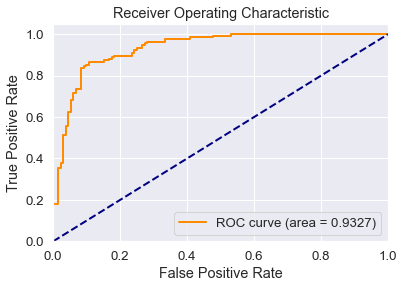

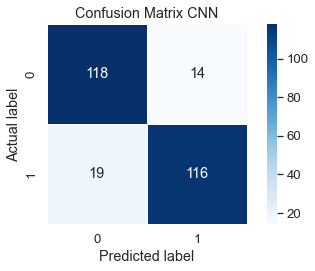

In [102]:

#------------------------------------------------------------------------------------------------------------------------------

#1.0	1.0 	1.0 	 2.0	[32, 32, 32]	['tanh', 'tanh', 'tanh']	binary_crossentropy 	Adamax
# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)


layers_dict = {
                'inic': {'type': 'input', 'shape': (14, 9, 1)},                                           # Input layer
                'conv1': {'type': 'conv2d', 'filters': 32, 'kernel_size': (3, 3), 'activation': 'tanh'},  # Convolutional layer 1
                'pool1': {'type': 'maxpooling2d', 'pool_size': (2, 2)},                                   # Max pooling layer 1
                'flatten': {'type': 'flatten'},                                                           # Flatten layer
                'dense1': {'type': 'dense', 'units': 32, 'activation': 'tanh'},                          # Dense layer 1
                'dense2': {'type': 'dense', 'units': 32, 'activation': 'tanh'},                          # Dense layer 1
                'end': {'type': 'dense', 'units': 1, 'activation': 'sigmoid'},                            # Output layer
                'compile': {'loss': 'binary_crossentropy', 'optimizer': 'Adamax' , 'metrics': ['accuracy']}
                }


model, results_df, predictions_CNN, predictions_proba_CNN, train_accuracyCNN, test_accuracyCNN = get_results(X_train_reshaped, X_test_reshaped, y_train, y_test, layers_dict, epochs=5, batch_size=1, verbose=1)
results_df = pd.DataFrame(results_df).T
results_df
print()


# accuracy
print(f"\nTraining Accuracy: {train_accuracyCNN:.4f}")
print(f"Test Accuracy: {test_accuracyCNN:.4f}")

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions_CNN))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, predictions_proba_CNN)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Plot heatmap of the confusion matrix
cm = confusion_matrix(y_test, predictions_CNN)
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix CNN')

# Adjust layout
plt.tight_layout()
plt.show()

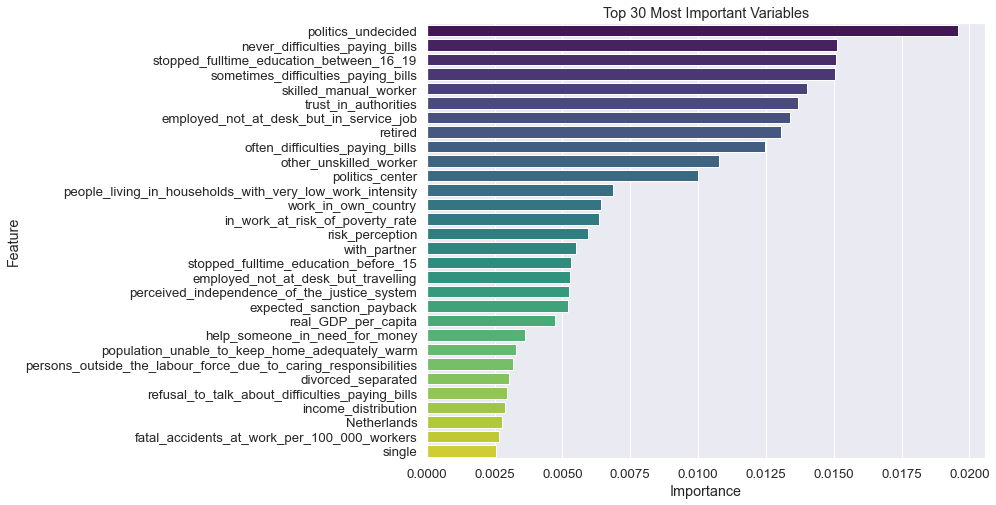

In [98]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# SET SEEDS
np.random.seed(140)
tf.random.set_seed(134)
tf.keras.utils.set_random_seed(44)
torch.manual_seed(140)

# Define and compile the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(14, 9, 1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=5, batch_size=1, shuffle=False, verbose=0)

# Function to compute integrated gradients
@tf.function
def integrated_gradients(input_data):
    baseline = tf.zeros_like(input_data)
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        predictions = model(input_data)
    grads = tape.gradient(predictions, input_data)
    integrated_grads = (input_data - baseline) * grads
    return tf.reduce_mean(integrated_grads, axis=0)

# Compute integrated gradients for each sample in the test set
ig_list = []
for sample in X_test_reshaped:
    ig = integrated_gradients(tf.convert_to_tensor([sample]))
    ig_list.append(ig.numpy())

# Calculate the mean importance across the test set
feature_importance = np.mean(ig_list, axis=0)

# Flatten feature_importance if it's not already 1D
feature_importance = feature_importance.flatten()

# Assuming X_train_reshaped was reshaped from a DataFrame X, with columns corresponding to the original feature names
input_feature_names = [f"Feature_{i}" for i in range(X_train_reshaped.shape[1] * X_train_reshaped.shape[2])]
input_feature_names = list(X.columns)

# Create a DataFrame to display the importance of each variable
importance_df = pd.DataFrame({'Feature': input_feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select only the top 30 most important variables
top_30_importance_df = importance_df.head(30)

# Plot the importance of top 30 variables
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_30_importance_df, palette='viridis', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Most Important Variables')
plt.show()


# ROC GRAPHICS

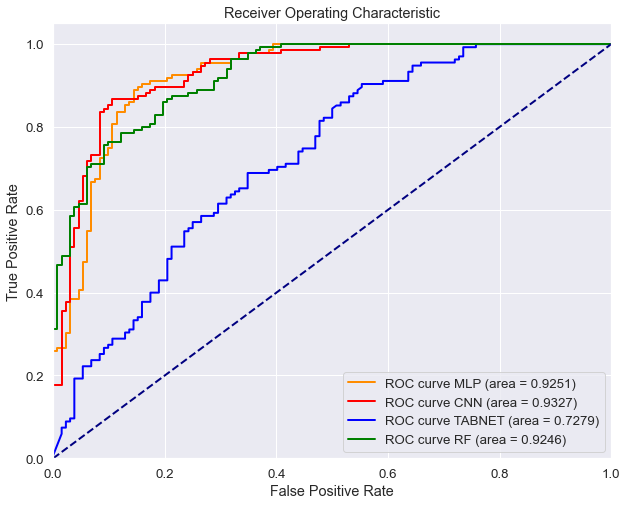

In [103]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))  # Adjust the size of the plot

# MLP
fpr1, tpr1, _ = roc_curve(y_test, y_pred_prob_MLP)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'ROC curve MLP (area = {roc_auc1:.4f})')

# CNN
fpr4, tpr4, _ = roc_curve(y_test, predictions_proba_CNN)
roc_auc4 = auc(fpr4, tpr4)
plt.plot(fpr4, tpr4, color='red', lw=2, label=f'ROC curve CNN (area = {roc_auc4:.4f})')

# TAB NET
fpr2, tpr2, _ = roc_curve(y_test, y_prob_TABNET)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, color='blue', lw=2, label=f'ROC curve TABNET (area = {roc_auc2:.4f})')

# RF
fpr3, tpr3, _ = roc_curve(y_test, y_pred_proba_RF)
roc_auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, color='green', lw=2, label=f'ROC curve RF (area = {roc_auc3:.4f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')  # Move legend to lower right corner
plt.show()



## Heatmap Confusion Matrix

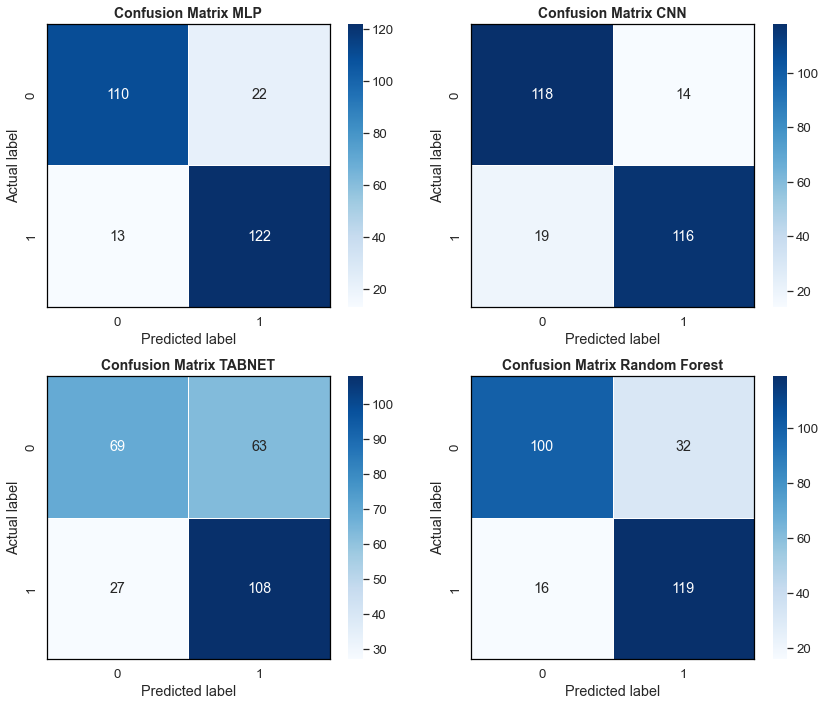

In [104]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Set common title properties
title_props = {'fontsize': 14, 'fontweight': 'bold'}

# Loop through each subplot and plot the confusion matrix
for i, ax in enumerate(axes.flat):
    if i == 0:
        cm = confusion_matrix(y_test, y_pred_MLP)
        title = 'Confusion Matrix MLP'
    elif i == 1:
        cm = confusion_matrix(y_test, predictions_CNN)
        title = 'Confusion Matrix CNN'
    elif i == 2:
        cm = confusion_matrix(y_test, y_test_pred_TABNET)
        title = 'Confusion Matrix TABNET'
    else:
        cm = confusion_matrix(y_test, y_pred_RF)
        title = 'Confusion Matrix Random Forest'
    
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', linewidths=1, square=True, cmap='Blues', ax=ax)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title, **title_props)
    
    # Draw borders around each heatmap
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')

# Adjust layout
plt.tight_layout()
plt.show()
